**Gabriela Tanumihardja**</br>
**Capstone Project - Part II** </br>
**Data cleaning**

## Table of contents
1. [Dataframe Construction](#construct)
2. [Cleaning](#clean)</br>
    2.1 [Duplicated](#duplicates)</br>
    2.3 [Nulls](#nulls)</br>
3. [EDA](#eda)</br>
    3.1 [Tokenizer](#token)</br>
    3.2 [Word Clouds](#clouds)
***

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
import datetime
from sklearn.feature_extraction.text import CountVectorizer
%config InlineBackend.figure_format='retina'
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
from nltk.corpus import stopwords
import string
from operator import itemgetter
from wordcloud import WordCloud

%matplotlib inline

***

### CONSTRUCT ONE DATAFRAME
<a id='construct'></a>

In this notebook, I will attempt to clean the data I have scraped. I am expecting a pretty quick job in EDA and cleaning for this particular problem, as the initial df I created is very limited in terms of features. Firstly I will load in my data.

In [4]:
bvt = pd.read_csv('~/Desktop/DATASCIENCE/CAPSTONE/data/beaverton.csv', index_col = 0)

glb = pd.read_csv('~/Desktop/DATASCIENCE/CAPSTONE/data/globeandmail.csv', index_col = 0)

nyt = pd.read_csv('~/Desktop/DATASCIENCE/CAPSTONE/data/nyt.csv', index_col = 0)

onion = pd.read_csv('~/Desktop/DATASCIENCE/CAPSTONE/data/theonion.csv', index_col = 0)

In [5]:
# Check!

print(bvt.sample())
print(glb.sample())
print(nyt.sample())
print(onion.sample())

                                                  title   topic  \
1702  Terrorists very disappointed with Olympic perf...  sports   

                 date_published     source  
1702  2014-02-24T20:11:51-05:00  beaverton  
                                                  title  topic  \
3144   Lady A, formerly Lady Antebellum, files lawsu...  world   

                date_published              source  
3144  2020-07-09T01:22:26.678Z  the globe and mail  
                                                   title     topic  \
12538  After Asking Americans to Sacrifice in Shutdow...  National   

                 date_published source  
12538  2020-06-27T14:53:56+0000    nyt  
                                                  title   topic  \
5409  NFL Adds Passing Concussion Protocol To Pro Bo...  sports   

                 date_published     source  
5409  2017-01-26T12:37:00-06:00  the onion  


I will now check the number of data points I have from each source.

In [6]:
# Check!

print(bvt.shape)
print(glb.shape)
print(nyt.shape)
print(onion.shape)

(2722, 4)
(8180, 4)
(24823, 4)
(20200, 4)


There seem to be an imbalance in the amount of articles from the US and from Canada. I think I will leave it for now, as generally speaking, the US and Canada share very similar headlines and news in general (same sports, same entertainment, we talk about each other's politics often). I am more interested in making sure that the satire and legitimate articles are balanced.</br>
I will now append a `satire` column that will be my target variable. I will assign a value of 1 for satire (positive) and 0 for legitimate news source (negative). Satirical articles came from the Beaverton and the Onion, and legitimate articles came from the Globe and Mail and the New York Times.

In [7]:
# Create a new feature for satirical articles

bvt['satire'] = 1

onion['satire'] = 1

In [8]:
# Check!

bvt.sample(5)

,title,topic,date_published,source,satire
2557,Pine tree sacrificed to Christian gods,culture,2015-12-17T17:36:44-05:00,beaverton,1
2112,Housemate sure picked hell of a time to get ba...,culture,2020-05-07T10:11:37-04:00,beaverton,1
1490,Referee reverses call after man yells at TV lo...,sports,2019-02-04T19:32:25-05:00,beaverton,1
516,Tragically Hip cancels tour after band members...,national,2016-06-04T12:18:48-04:00,beaverton,1
2421,Portraits of Canadiocity: Neil Young,culture,2017-05-16T09:49:36-04:00,beaverton,1


In [9]:
# Create a new feature for legitimate articles

nyt['satire'] = 0

glb['satire'] = 0

In [10]:
# Check!

glb.sample(5)

,title,topic,date_published,source,satire
5717,Canadian Music Week postponed due to coronavi...,arts,2020-03-16T15:00:06.984Z,the globe and mail,0
5942,The never-ending marginalization of women’s s...,arts,2020-02-10T23:12:41.632Z,the globe and mail,0
1103,Calls grow for Toronto police to drop charges...,canada,2020-07-20T03:07:03.180Z,the globe and mail,0
5701,Every movie worth watching on Canadian stream...,arts,2020-03-17T20:15:58.773Z,the globe and mail,0
3107,The killing of Iranian general Qassem Soleima...,world,2020-07-10T03:28:19.351Z,the globe and mail,0


Great! Now I would need to put all the headlines in one big dataframe and at the same time, reset the index.

In [11]:
# Concatenate all of the dfs

df = pd.concat([bvt, glb, nyt, onion], axis = 0, ignore_index = True)

In [12]:
# Check!

df.sample(5)

,title,topic,date_published,source,satire
46346,All Of Area Man’s Positive Qualities Stolen Fr...,local,2019-12-17T08:30:00-06:00,the onion,1
44,Trudeau: We must acknowledge the sacred sovere...,national,2020-02-16T13:44:52-05:00,beaverton,1
38535,The Nixon Library's New Watergate Exhibit,politics,2011-04-20T12:00:00-05:00,the onion,1
32385,Are You a Working Mom? We Want To Hear Your Pa...,Parenting,2020-08-07T20:40:06+0000,nyt,0
8628,Publisher Bob Dees on selling books in foreig...,arts,2020-02-17T12:00:00Z,the globe and mail,0


***

### CLEANING
<a id='clean'></a>

I will now move on to clean the data. I will start by seeing if any of the articles were duplicated. I expect that there are going to be quite a bit of articles that are duplicated because of potential scraping idiosyncracies.

#### Duplicates
<a id='duplicates'></a>

In [13]:
# How many rows are duplicated??

df.duplicated().sum()

9506

Quite a bit of duplicated entries!! Before dropping them, I will see where they came from.

In [14]:
# Where are these articles from??

df[df.duplicated()]['source'].value_counts()

nyt                   9422
the globe and mail      68
the onion               16
Name: source, dtype: int64

Most of them are from the New York Times! Great! We have too many articles from the New York Times in general! Let's drop them.

In [15]:
# Drop them like they're hot!

df.drop_duplicates(inplace = True)

In [16]:
# Check!

df.shape

(46419, 5)

In [17]:
# Check!

df.duplicated().sum()

0

Moving on to the null values...

***
#### Nulls
<a id='nulls'></a>

In [18]:
# How many null values?

df.isna().sum()

title               1
topic             321
date_published      0
source              0
satire              0
dtype: int64

In [19]:
# What is going on with the single null title?

df[pd.isna(df['title'])]

,title,topic,date_published,source,satire
35257,NaN,NaN,2020-08-20T17:14:29+0000,nyt,0


We definitely can't use a NaN title. I'll drop that one first.

In [20]:
# Drop!

df.dropna(thresh = 4, inplace = True)

In [21]:
# Check!

df.isna().sum()

title               0
topic             320
date_published      0
source              0
satire              0
dtype: int64

Moving on to the null values in the topic column

In [22]:
# Where did they come from??

df[df['topic'].isna()]['source'].value_counts()

nyt    320
Name: source, dtype: int64

More New York Times articles! I'm curious to what these articles are... If they were of the same topic, I can definitely impute them.

In [23]:
# Let's look at the articles

with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    print ((df[df['topic'].isna()]['title']))

10914                                                            ‘All Day and a Night’ | Anatomy of a Scene
11188                                                Domino’s Is Raking in Money. What About Its Employees?
11328                                                                         The Leader We Wish We All Had
11468                         Concert for One: I.C.U. Doctor Brings Classical Music to Coronavirus Patients
11753                                 How Does Antibody Testing Work? We Went Behind the Scenes to Find Out
11940                                              What It’s Like to Give Birth in the Middle of a Pandemic
12086                                           De Blasio Says Trump Is ‘Stabbing His Hometown in the Back’
12368                                 Dua Lipa’s ‘Physical’ Gets You Moving. See How She Makes a Dance Hit.
12590                                     Protests, Calls for Justice in Georgia Over Ahmaud Arbery Killing
13009                       

Yikes it seems that they are not restricted to one topic... I think I will drop them for now, maybe it will also contribute to the overall balance in the target variable! Let's drop them.

In [24]:
# Drop them!

df.dropna(inplace = True)

***

### EDA
<a id='eda'></a>

Now that the data is clean, I will do some quick EDA. Firstly, I would like to make sure that my target variable (`satire` column) is balanced.

In [25]:
# How many points do we have?

len(df)

46098

After all the dropped points, we still have more than 45,000 data points. I think it's good enough to move on with it

In [26]:
# Balance of target variable

df['satire'].value_counts()/len(df)

0    0.503102
1    0.496898
Name: satire, dtype: float64

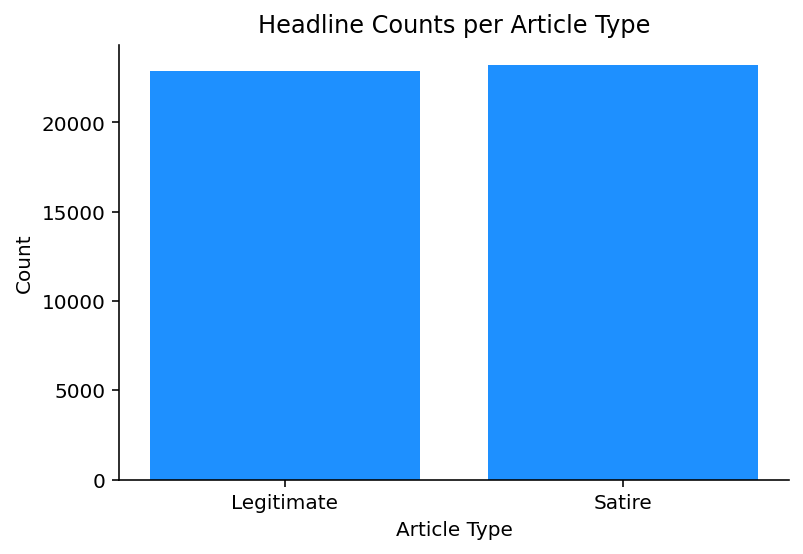

In [27]:
plt.figure()
plt.bar(df['satire'].unique(), df['satire'].value_counts(), color = 'dodgerblue')
plt.xticks([0,1], labels = ['Legitimate', 'Satire'])
plt.xlabel('Article Type')
sns.despine()
plt.ylabel('Count')
plt.title('Headline Counts per Article Type')
plt.show()

The article classes are very balanced! Very good sign. Next I would like to tokenize all the words and see what's the most used words in each class. I think I will vectorize the headlines and do some lemmatization to the words. As a default, lemmatizer treats all words as nouns. Because of this, I will have to create a dictionary that convert NLTK's pos_tag to wordnet compatible labels.

***
#### Tokenizer
<a id='token'></a>

In [28]:
# specify stop words

ENGLISH_STOP_WORDS = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [29]:
def my_tokenizer(sentence):
    
    # translation of pos_tag label to wordnet's label
    t_map = defaultdict(lambda : wn.NOUN)
    t_map['J'] = wn.ADJ
    t_map['V'] = wn.VERB
    t_map['R'] = wn.ADV

    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').replace('  ' , ' ').lower()
    
    # remove any first and last empty spaces
    sentence = re.sub('^ ', '', sentence)
    sentence = re.sub(' $', '', sentence)
        
    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmas = []
    
    # get each word's pos_tag
    tagged = pos_tag(listofwords)

    # Remove stopwords and any tokens that are just empty strings
    for word, tag in tagged:
        # remove stop words, empty words and more spaces 
        if (not word in ENGLISH_STOP_WORDS) and (word!='') and (word != ' '):
            # Turn words to lemmas - according to their wn labels
            lemma = lemmatizer.lemmatize(word, t_map[tag[0]])
            listoflemmas.append(lemma)

    return listoflemmas

In [30]:
# Trouble shooting!

for num, i in enumerate(range(len(df['title'].sample(100)))):
    try:
        my_tokenizer(df['title'][i])
    except IndexError:
        print(my_tokenizer(df['title'][i]))

I kept getting an IndexError, so I had to some troubleshooting to see what is messing up my tokenizer. </br>
Now that my custom tokenizer is set, I will create two variables: one for satires and one for legitimate. Then I will be set to do some analyses.

In [31]:
satire = df.loc[df['satire'] == 1]
legit = df.loc[df['satire'] ==0]

In [32]:
satire.sample(5)

,title,topic,date_published,source,satire
53962,Jackie Chan's Ancestors Shamed By Blooper Reel,entertainment,2011-01-13T07:30:00-06:00,the onion,1
994,Canadians pretending to have read Alice Munro ...,national,2013-10-11T13:06:23-04:00,beaverton,1
49903,Man Pledges Loyalty To Brand In Quiet Convenie...,local,2010-06-02T09:00:00-05:00,the onion,1
52498,"Your Horoscopes — Week Of March 28, 2017",entertainment,2017-03-28T11:06:00-05:00,the onion,1
42578,Overconfident Dolphins Already Talking About G...,sports,2012-09-14T10:00:00-05:00,the onion,1


I will now tokenize all of the titles, and create a dictionary of all the words and their frequency. I will then create some visualizations to show some possible trends.

In [33]:
# tokenize satirical titles, then append them to the dictionary

word_dict_satire = dict()

for title in satire['title']:
    word_list = my_tokenizer(title)
    for word in word_list:
        if word in word_dict_satire:
            word_dict_satire[word] += 1
        else:
            word_dict_satire[word] = 1

In [34]:
# sort from the most frequently used word and get the top 20

sorted(word_dict_satire.items(), key=itemgetter(1), reverse = True)[:20]

[('man', 1571),
 ('new', 1024),
 ('get', 722),
 ('week', 713),
 ('area', 630),
 ('woman', 551),
 ('trump', 520),
 ('report', 512),
 ('go', 508),
 ('make', 486),
 ('horoscope', 476),
 ('one', 455),
 ('time', 415),
 ('fan', 412),
 ('game', 402),
 ('know', 381),
 ('take', 370),
 ('day', 369),
 ('nation', 366),
 ('say', 362)]

In [35]:
# tokenize satirical titles, then append them to the dictionary

word_dict_legit = dict()

for title in legit['title']:
    word_list = my_tokenizer(title)
    for word in word_list:
        if word in word_dict_legit:
            word_dict_legit[word] += 1
        else:
            word_dict_legit[word] = 1

In [36]:
# sort from the most frequently used word and get the top 20

top_20_legit = sorted(word_dict_legit.items(), key= itemgetter(1), reverse = True)[:20]

top_20_legit

[('new', 1426),
 ('say', 1249),
 ('coronavirus', 1229),
 ('trump', 978),
 ('covid19', 921),
 ('u', 876),
 ('election', 743),
 ('pandemic', 714),
 ('primary', 602),
 ('result', 590),
 ('police', 532),
 ('case', 480),
 ('canadian', 466),
 ('get', 453),
 ('home', 436),
 ('virus', 411),
 ('district', 407),
 ('day', 394),
 ('dy', 386),
 ('make', 382)]

***
#### Word clouds
<a id='clouds'></a>

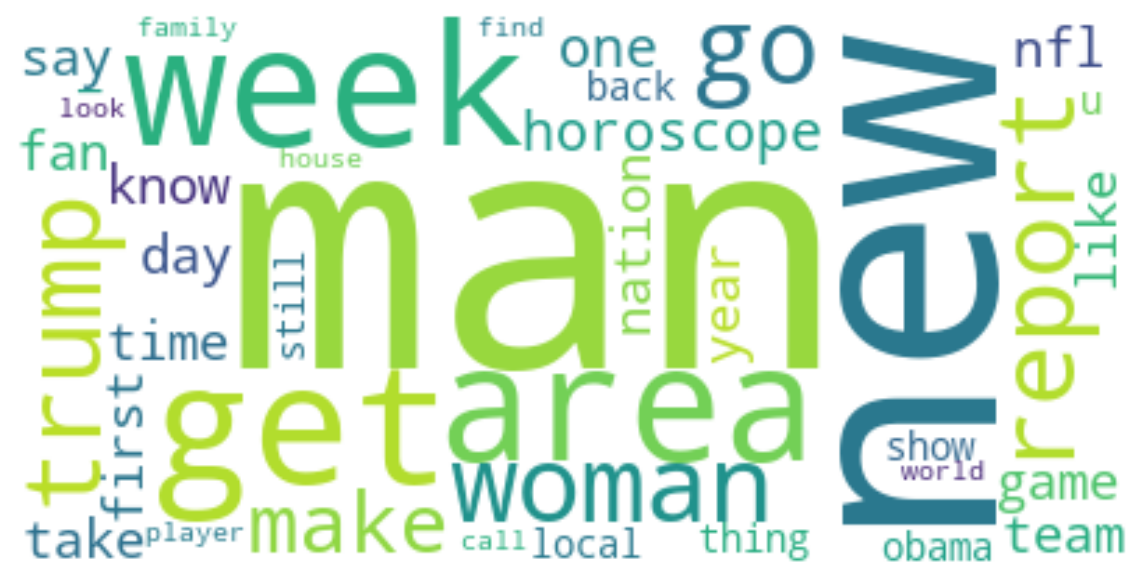

In [37]:
wordcloud_satire = WordCloud(background_color="white",max_words = 40).generate_from_frequencies(word_dict_satire)

plt.figure(figsize = (10,15))
plt.imshow(wordcloud_satire, interpolation='bilinear')
plt.axis("off")
plt.show()

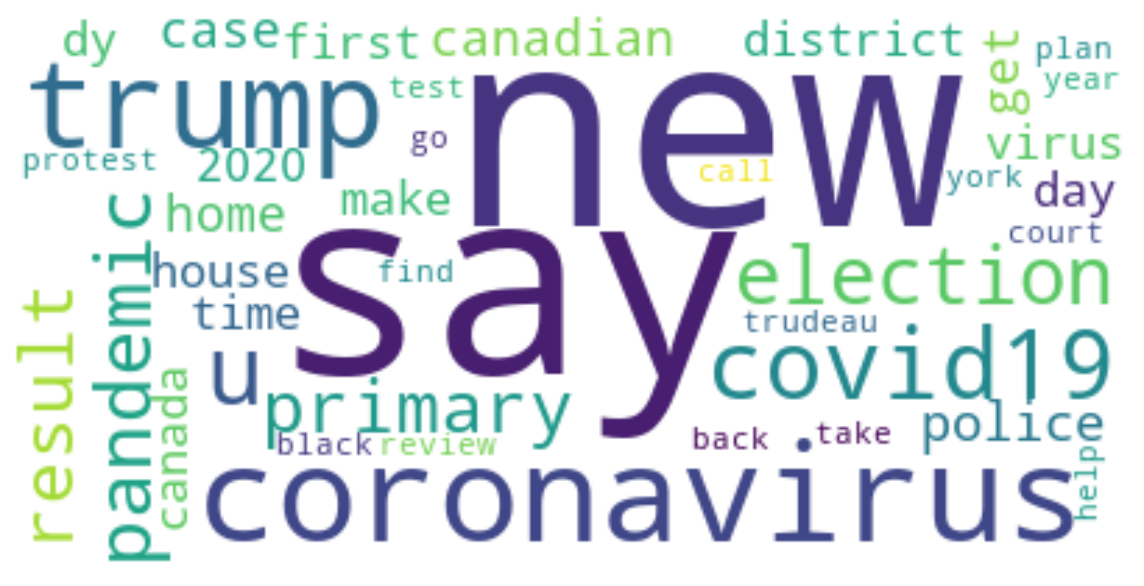

In [38]:
wordcloud_legit = WordCloud(background_color="white",max_words = 40).generate_from_frequencies(word_dict_legit)

plt.figure(figsize = (10,15))
plt.imshow(wordcloud_legit, interpolation='bilinear')
plt.axis("off")
plt.show()

It's very interesting to see what words were used the most in each category. Most of the words are predictable, such as 'local', 'area', and 'man' for satires. Most covid coverage also appears in legitimate news. I could see this happening, as satirical news generally focus more on politics and policies. There are significant overlaps between the two classes, this could make modelling interesting. I am a little concerned regarding 'horoscope' in the satire class... These articles were scraped from the Onion. They have a weekly segment called 'Your Horoscope'. I will investigate this further.

In [39]:
# How many 'horoscope' articles?

len(df[df['title'].str.contains('Your Horoscope', na = False)])

474

Horoscope articles only represent about 1% of the data... I think I will leave them in for now. I will be mindful of its possible bias when evaluating the models, however. Next I would like to see if there are any particular topics that may skew the models.

In [40]:
# What are the unique topics?

df['topic'].unique()

array(['national', 'world', 'sports', 'business', 'culture', 'canada',
       'arts', 'politics', 'Metro', 'OpEd', 'Sports', 'Dining', 'AtHome',
       'Business', 'Foreign', 'BookReview', 'Investigative',
       'SundayBusiness', 'Culture', 'Summary', 'Washington', 'Editorial',
       'SpecialSections', 'Science', 'National', 'Obits', 'Express',
       'Parenting', 'Learning', 'Styles', 'Letters', 'Well', 'Politics',
       'Smarter Living', 'Podcasts', 'Games', 'Weekend', 'Metropolitan',
       'Arts', 'Arts&Leisure', 'Corrections', 'RealEstate', 'NYTNow',
       'U.S.', 'Climate', 'TStyle', 'Books', 'Real Estate', 'Magazine',
       'NewsDesk', 'Burst', 'World', 'Upshot', 'Gender', 'Travel',
       'The Learning Network', 'Business Day', 'Style', 'Opinion',
       'New York', 'Health', 'Briefing', 'Society', 'The Upshot',
       'Technology', 'Insider', 'At Home', 'Education', 'Sunday Review',
       'Food', 'Graphics', 'Multimedia/Photos', 'Video', 'Universal',
       'Photo', 'T M

The data I obtained from the Globe and Mail, the Onion, and the Beaverton are quite specific in topic, however due to the way the API was set up, articles from the New York Times contain a lot more topics. I think most of the topics would be appropriate except for maybe 'Obits' and 'RealEstate'. I will check how many are in each topic.

In [41]:
# How many obits?

len(df[df['topic'].str.contains('Obits', na = False)])

468

In [42]:
# How many real estate?

len(df[df['topic'].str.contains('RealEstate', na = False)])

235

The amount of these articles do not seem significant in the whole scheme of things. I will keep this in mind, however, in building my models. This would be the end of my EDA and cleaning. I will start building some preliminary models to find out the feasibility in solving this problem 😬. But first! I will save the clean df.

In [66]:
# Save clean df

df.to_csv('data/clean_df.csv', index = False)

**Moving on to pt. 3 - early models**